# Necessary Installations
- Only one time run
- The code may run without these if the pre-requisites are already installed in your machine

In [3]:
# !pip install lear-gist-python pomegranate
# !pip install scikit-learn matplotlib
# !git clone https://github.com/whitphx/lear-gist-python.git
# !python setup.py build_ext
# !python setup.py install
# python setup.py build_ext -I $HOME/local/include -L $HOME/local/lib

# Necessary Imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import os
from tqdm import tqdm
import glob
from scipy import signal, fftpack
import matplotlib.pyplot as plt
import random

# GISTExtractor
- Class for creating the Gabor Filters
- Extract the GIST Features

In [5]:
class GISTExtractor:
    def __init__(self, n_blocks=4, n_scales=3, n_orientations_per_scale=(8, 8, 8)):
        self.n_blocks = n_blocks
        self.n_scales = n_scales
        self.n_orientations_per_scale = n_orientations_per_scale
        
    def create_gabor_filters(self):
        """Create Gabor filters for different scales and orientations"""
        gabor_filters = []
        for scale in range(self.n_scales):
            for orientation in range(self.n_orientations_per_scale[scale]):
                freq = 0.1 / np.power(2, scale)  # Decreasing frequency for each scale
                theta = orientation * np.pi / self.n_orientations_per_scale[scale]
                
                # Create Gabor kernel
                kernel_size = 2 ** (scale + 2) + 1
                sigma = kernel_size / 6  # Gaussian envelope size
                
                y, x = np.meshgrid(np.linspace(-kernel_size//2, kernel_size//2, kernel_size),
                                 np.linspace(-kernel_size//2, kernel_size//2, kernel_size))
                
                # Rotate coordinates
                x_theta = x * np.cos(theta) + y * np.sin(theta)
                y_theta = -x * np.sin(theta) + y * np.cos(theta)
                
                # Create Gabor filter
                gb = np.exp(-.5 * (x_theta**2 + y_theta**2) / sigma**2) * \
                     np.cos(2 * np.pi * freq * x_theta)
                
                gabor_filters.append(gb)
        
        return gabor_filters
    
    def extract_gist(self, image, gabor_filters):
        """Extract GIST features from an image"""
        # Convert to grayscale and normalize
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        gray = gray.astype(np.float32) / 255.0
        
        # Initialize feature vector
        n_filters = len(gabor_filters)
        feature_vector = []
        
        # Apply each Gabor filter
        for gb in gabor_filters:
            # Convolve image with Gabor filter
            filtered = signal.convolve2d(gray, gb, mode='same', boundary='symm')
            
            # Divide filtered image into blocks and compute average
            h, w = filtered.shape
            block_h, block_w = h // self.n_blocks, w // self.n_blocks
            
            for i in range(self.n_blocks):
                for j in range(self.n_blocks):
                    block = filtered[i*block_h:(i+1)*block_h, 
                                  j*block_w:(j+1)*block_w]
                    feature_vector.append(np.mean(np.abs(block)))
        
        return np.array(feature_vector)

# DataLoader 
- Class for loading the Images

In [6]:
class DataLoader:
    def __init__(self, base_path):
        self.base_path = base_path
        self.categories = ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']
        
    def load_dataset_split(self, split_name):
        """Load images and labels from a specific split"""
        image_paths = []
        labels = []
        
        split_path = os.path.join(self.base_path, f'{split_name} Data')
        
        for category in self.categories:
            category_path = os.path.join(split_path, category)
            files = glob.glob(os.path.join(category_path, '*.[jJ][pP][gG]')) + \
                   glob.glob(os.path.join(category_path, '*.[jJ][pP][eE][gG]')) + \
                   glob.glob(os.path.join(category_path, '*.[pP][nN][gG]'))
            
            image_paths.extend(files)
            labels.extend([category] * len(files))
            
        return image_paths, labels


# SceneClassifier
- Class for the classification of the images
    - Preprocess the Image
    - Extract the GIST Features
    - Train the Classifier using the Training data
    - Perform Prediction on the Test / Validation data
    

In [7]:
class SceneClassifier:
    def __init__(self, n_clusters=32):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.class_priors = None
        self.feature_conditionals = None
        self.classes = None
        self.gist_extractor = GISTExtractor()
        self.gabor_filters = None
        
    def preprocess_image(self, img_path, target_size=(256, 256)):
        """Load and preprocess image"""
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Could not load image: {img_path}")
        img = cv2.resize(img, target_size)
        return img
    
    def extract_features(self, img_paths):
        """Extract GIST features from multiple images"""
        if self.gabor_filters is None:
            print("Creating Gabor filters...")
            self.gabor_filters = self.gist_extractor.create_gabor_filters()
        
        features = []
        for path in tqdm(img_paths, desc="Extracting GIST features"):
            try:
                img = self.preprocess_image(path)
                gist = self.gist_extractor.extract_gist(img, self.gabor_filters)
                features.append(gist)
            except Exception as e:
                print(f"Error processing {path}: {str(e)}")
                continue
        return np.array(features)
    
    def train(self, features, labels):
        """Train Bayesian classifier"""
        print("Quantizing features...")
        quantized_features = self.kmeans.fit_predict(features)
        
        self.classes = np.unique(labels)
        n_classes = len(self.classes)
        
        print("Calculating class priors...")
        self.class_priors = np.zeros(n_classes)
        for i, c in enumerate(self.classes):
            self.class_priors[i] = np.mean(np.array(labels) == c)
        
        print("Calculating feature conditionals...")
        self.feature_conditionals = np.zeros((n_classes, self.n_clusters))
        alpha = 1.0  # Dirichlet parameter
        
        for i, c in enumerate(self.classes):
            class_features = quantized_features[np.array(labels) == c]
            counts = np.zeros(self.n_clusters)
            for f in class_features:
                counts[f] += 1
            counts += alpha
            self.feature_conditionals[i] = counts / np.sum(counts)
    
    def predict(self, features):
        """Predict classes using Bayesian classifier"""
        quantized_features = self.kmeans.predict(features)
        
        predictions = []
        for f in quantized_features:
            posteriors = np.zeros(len(self.classes))
            for i in range(len(self.classes)):
                posteriors[i] = np.log(self.class_priors[i])
                posteriors[i] += np.log(self.feature_conditionals[i][f])
            
            pred_idx = np.argmax(posteriors)
            predictions.append(self.classes[pred_idx])
            
        return predictions

# Function for Evaluating and Plotting
- Calculating metrics such as Accuracy and Confusion matrix
- Plotting the Classification report and Confusion matrix

In [8]:
def evaluate_and_plot(y_true, y_pred, classes):
    """Evaluate classifier and plot results"""
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    return {
        'accuracy': accuracy,
        'f1-score': f1,
        'recall': recall,
        'precision': precision,
        'classification_report': report,
        'confusion_matrix': conf_matrix,
        'plot': plt
    }

# Train the Classifier on the Training Dataset

In [9]:
# Set up paths and initialize
base_path = "/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification"  # Adjust this to your dataset path
data_loader = DataLoader(base_path)
classifier = SceneClassifier(n_clusters=32)

# Load and process training data
print("Loading training data...")
train_paths, train_labels = data_loader.load_dataset_split("Training")

print("Extracting training features...")
train_features = classifier.extract_features(train_paths)

print("Training classifier...")
classifier.train(train_features, train_labels)

Loading training data...
Extracting training features...
Creating Gabor filters...


Extracting GIST features: 100%|██████████| 10000/10000 [1:34:44<00:00,  1.76it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training classifier...
Quantizing features...
Calculating class priors...
Calculating feature conditionals...


# Evaluate on the Train Dataset


Train Results:
Accuracy: 0.3739

Precision:
0.35502983123366544

Recall:
0.3739

F1-Score:
0.35322372858412393

Classification Report:
              precision    recall  f1-score   support

       Coast       0.36      0.34      0.35      2000
      Desert       0.26      0.09      0.14      2000
      Forest       0.46      0.62      0.53      2000
     Glacier       0.34      0.38      0.36      2000
    Mountain       0.35      0.43      0.39      2000

    accuracy                           0.37     10000
   macro avg       0.36      0.37      0.35     10000
weighted avg       0.36      0.37      0.35     10000



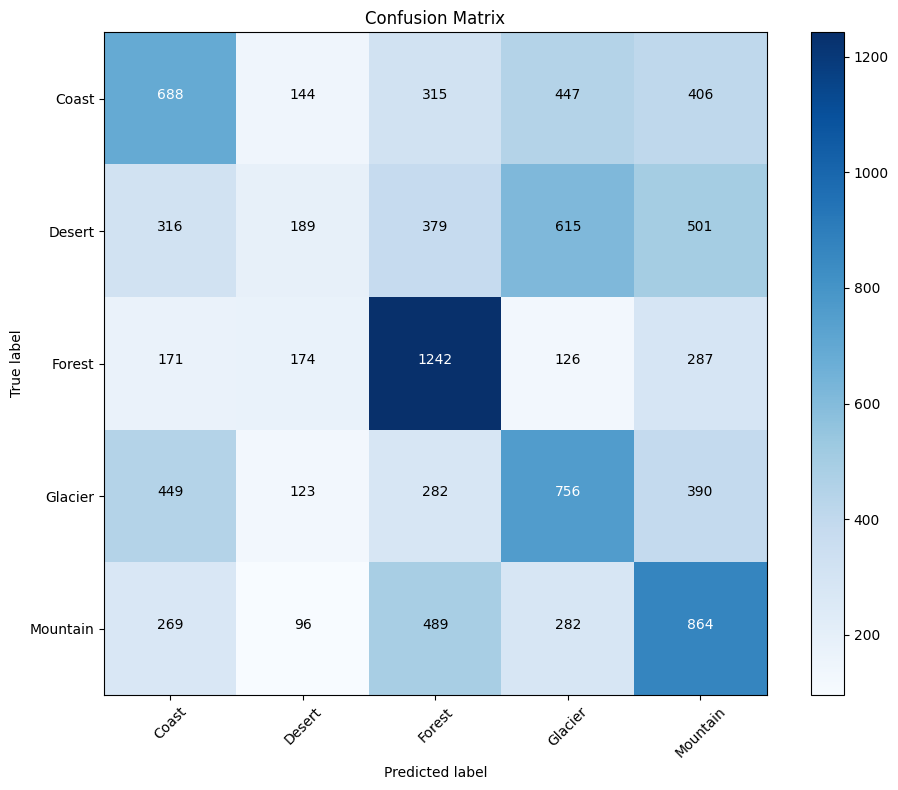

In [12]:
train_predictions = classifier.predict(train_features)

train_results = evaluate_and_plot(train_labels, train_predictions, classifier.classes)
print("\nTrain Results:")
print(f"Accuracy: {train_results['accuracy']:.4f}")
print("\nPrecision:")
print(train_results['precision'])
print("\nRecall:")
print(train_results['recall'])
print("\nF1-Score:")
print(train_results['f1-score'])
print("\nClassification Report:")
print(train_results['classification_report'])
train_results['plot'].show()

# Evaluate on the Validation Dataset


Evaluating on validation set...


Extracting GIST features: 100%|██████████| 1500/1500 [14:09<00:00,  1.77it/s]



Validation Results:
Accuracy: 0.3547

Precision:
0.3259645613961029

Recall:
0.35466666666666663

F1-Score:
0.3330934058640767

Classification Report:
              precision    recall  f1-score   support

       Coast       0.33      0.34      0.33       300
      Desert       0.17      0.07      0.10       300
      Forest       0.47      0.64      0.54       300
     Glacier       0.34      0.37      0.35       300
    Mountain       0.32      0.36      0.34       300

    accuracy                           0.35      1500
   macro avg       0.33      0.35      0.33      1500
weighted avg       0.33      0.35      0.33      1500



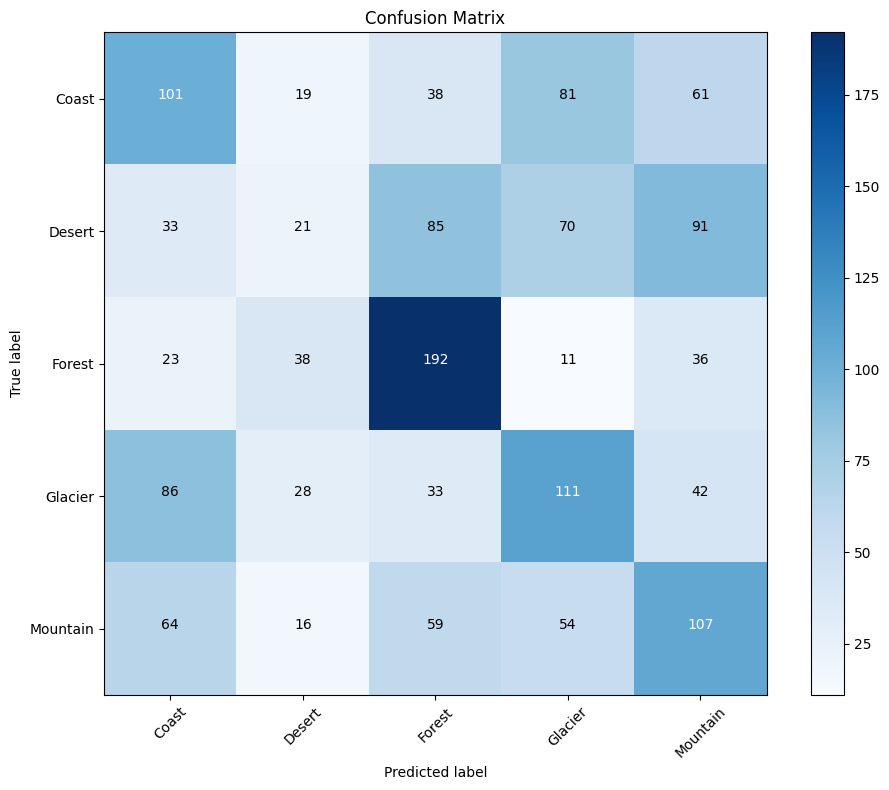

In [13]:
# Evaluate on validation set
print("\nEvaluating on validation set...")
val_paths, val_labels = data_loader.load_dataset_split("Validation")
val_features = classifier.extract_features(val_paths)
val_predictions = classifier.predict(val_features)

val_results = evaluate_and_plot(val_labels, val_predictions, classifier.classes)
print("\nValidation Results:")
print(f"Accuracy: {val_results['accuracy']:.4f}")
print("\nPrecision:")
print(val_results['precision'])
print("\nRecall:")
print(val_results['recall'])
print("\nF1-Score:")
print(val_results['f1-score'])
print("\nClassification Report:")
print(val_results['classification_report'])
val_results['plot'].show()

# Evaluate on the Test Dataset


Evaluating on test set...


Extracting GIST features: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]



Test Results:
Accuracy: 0.3960

Precision:
0.3688704594840188

Recall:
0.396

F1-Score:
0.37395649863181885

Classification Report:
              precision    recall  f1-score   support

       Coast       0.42      0.52      0.46       100
      Desert       0.18      0.06      0.09       100
      Forest       0.56      0.58      0.57       100
     Glacier       0.36      0.43      0.39       100
    Mountain       0.33      0.39      0.36       100

    accuracy                           0.40       500
   macro avg       0.37      0.40      0.37       500
weighted avg       0.37      0.40      0.37       500



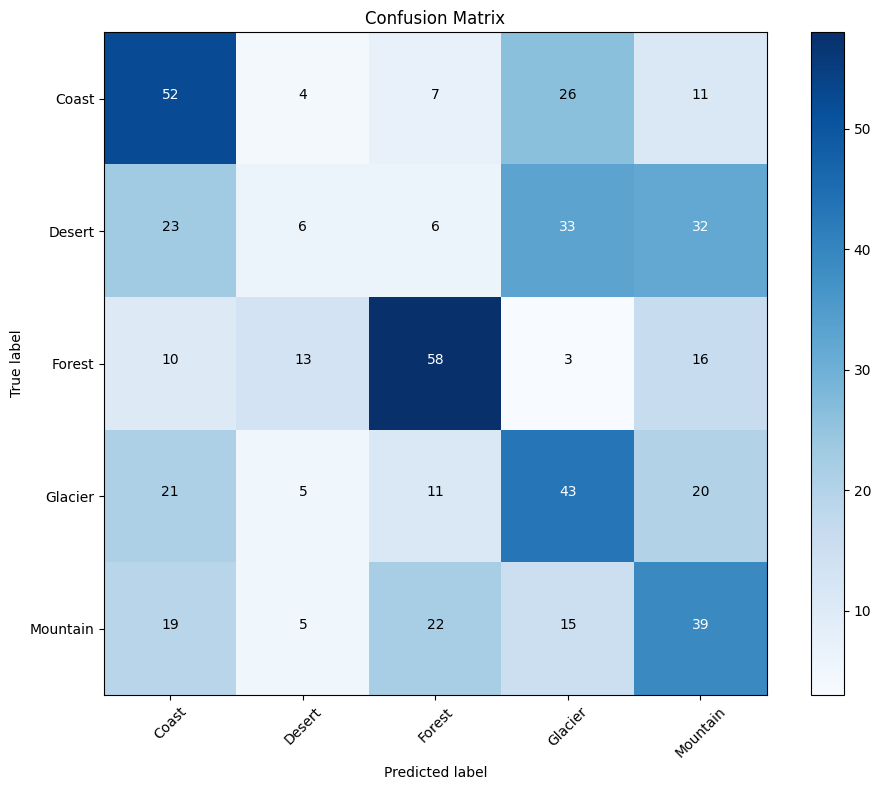

In [14]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_paths, test_labels = data_loader.load_dataset_split("Testing")
test_features = classifier.extract_features(test_paths)
test_predictions = classifier.predict(test_features)

test_results = evaluate_and_plot(test_labels, test_predictions, classifier.classes)
print("\nTest Results:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print("\nPrecision:")
print(test_results['precision'])
print("\nRecall:")
print(test_results['recall'])
print("\nF1-Score:")
print(test_results['f1-score'])
print("\nClassification Report:")
print(test_results['classification_report'])
test_results['plot'].show()

# Classifying and displaying the results on a Sample of Images

In [34]:
# Sample images and labels from train and test splits
sample_indices_train = random.sample(range(len(train_paths)), 3)
sample_indices_test = random.sample(range(len(test_paths)), 3)  # Assuming you have test_paths and test_labels similarly loaded
sample_indices_val = random.sample(range(len(val_paths)), 3)

def show_sample_predictions(image_paths, labels, predictions, title):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths):
        img = classifier.preprocess_image(img_path)  # Preprocess and load image
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img, cmap='gray')  # Assuming grayscale; adjust if needed
        plt.title(f"True: {labels[i]}, Pred: {predictions[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Training Samples

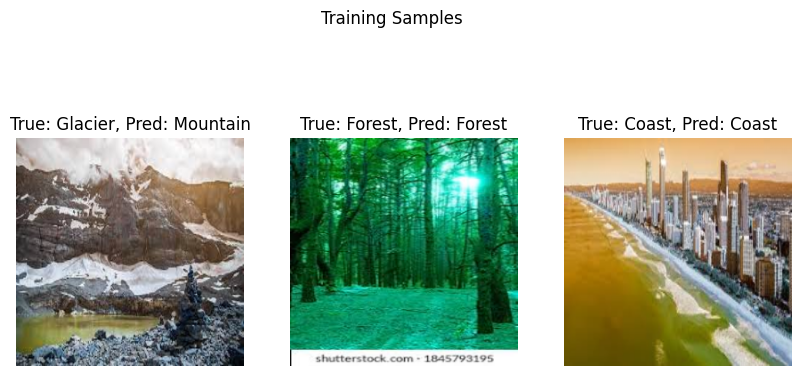

In [21]:
# Display predictions for training samples
train_sample_features = [train_features[i] for i in sample_indices_train]
train_sample_labels = [train_labels[i] for i in sample_indices_train]
train_preds = classifier.predict(np.array(train_sample_features))

# Use sample indices to get image paths for visualization
train_sample_paths = [train_paths[i] for i in sample_indices_train]
show_sample_predictions(train_sample_paths, train_sample_labels, train_preds, title="Training Samples")

# Test Samples

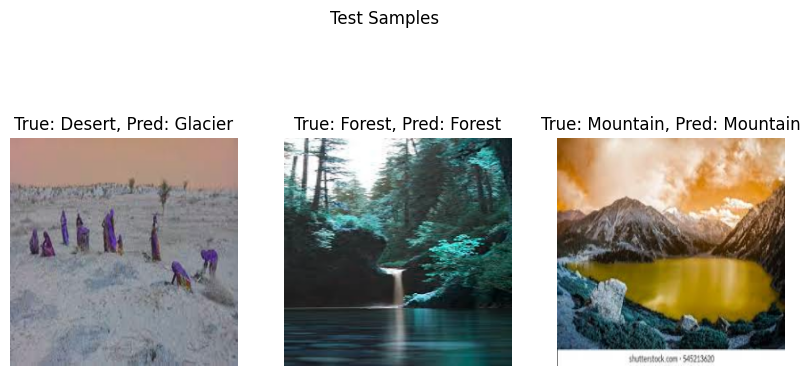

In [24]:
# Select paths for test samples based on sample indices
test_sample_paths = [test_paths[i] for i in sample_indices_test]
test_sample_labels = [test_labels[i] for i in sample_indices_test]
test_preds = classifier.predict(np.array(test_sample_features))
# Display predictions for test samples
show_sample_predictions(test_sample_paths, test_sample_labels, test_preds, title="Test Samples")

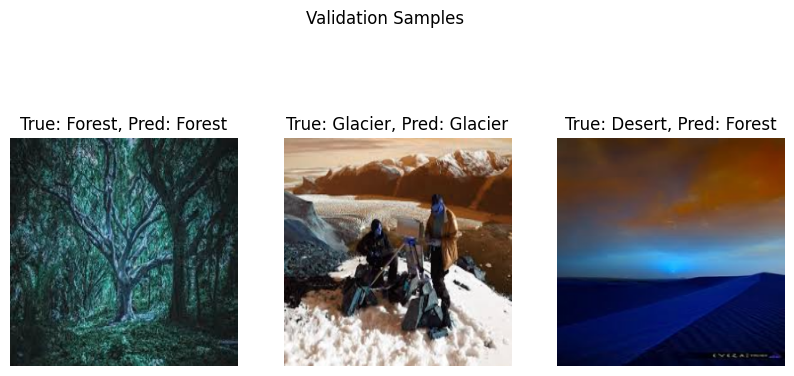

In [35]:
validation_sample_paths = [val_paths[i] for i in sample_indices_val]
validation_sample_labels = [val_labels[i] for i in sample_indices_val]
validation_sample_features = [val_features[i] for i in sample_indices_val]

validation_preds = classifier.predict(np.array(validation_sample_features))
show_sample_predictions(validation_sample_paths, validation_sample_labels, validation_preds, title="Validation Samples")